In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import datetime

In [2]:
# Project time frame
start_date = "2020-01-01"
end_date = "2025-05-01"

# Benchmark index
benchmark_symbol = "^GSPC"

# Top 10 symbols from each sector (replace with your actual tickers if needed)
sectors = {
    "Technology": ["AAPL"],
    # "Technology": ["AAPL", "MSFT", "NVDA", "AVGO", "ADBE", "CRM", "AMD", "CSCO", "INTC", "ORCL"],
    # "Communication": ["GOOGL", "META", "NFLX", "TMUS", "DIS", "VZ", "T", "CHTR", "CMCSA", "WBD"],
    # "Health": ["JNJ", "PFE", "ABBV", "LLY", "MRK", "TMO", "BMY", "UNH", "ABT", "CVS"],
    # "Financials": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "USB", "BK", "SCHW"],
    # "Defensive": ["PG", "KO", "PEP", "WMT", "COST", "CL", "MO", "KMB", "MDLZ", "KR"],
    # "Cyclical": ["AMZN", "HD", "LOW", "MCD", "NKE", "SBUX", "BKNG", "TGT", "EBAY", "GM"],
    # "Property": ["PLD", "AMT", "CCI", "EQIX", "DLR"benchmark_symbol "SPG", "O", "PSA", "VTR", "EXR"],
    "Benchmark": [benchmark_symbol]
}

# Flatten list of all tickers
all_symbols = [symbol for group in sectors.values() for symbol in group]

### Load from CSV

In [3]:
# Load dataset from CSV
import os

if os.path.exists("stock_sector_data.csv"):
    stock_df = pd.read_csv("stock_sector_data.csv", parse_dates=["Date"])
    print("Loaded dataset from CSV.")
else:
    print("CSV file not found. Please run the download step.")
    
# Drop any rows that are not in sectors dictionary
stock_df = stock_df[stock_df["Symbol"].isin(all_symbols)]
    

# Drop any rows with symbol that match the benchmark symbol
stock_df = stock_df[stock_df["Symbol"] != benchmark_symbol]


Loaded dataset from CSV.


### Feature Engineering — Add Technical Indicators


In [4]:
def add_technical_indicators(df):
    result = []

    for symbol in df["Symbol"].unique():
        sub = df[df["Symbol"] == symbol].sort_values("Date").copy()

        # Momentum: past 1-week and 4-week returns
        sub["Return_1w"] = sub["Close"].pct_change(1)
        sub["Return_4w"] = sub["Close"].pct_change(4)

        # Volatility: Rolling std dev
        sub["Volatility_4w"] = sub["Close"].rolling(window=4).std()
        
        # Moving averages
        sub['MA5'] = sub['Close'].rolling(window=5).mean()
        sub['MA20'] = sub['Close'].rolling(window=20).mean()
        sub['MA50'] = sub['Close'].rolling(window=50).mean()
        
        # Volume indicators
        sub['Volume_Change'] = sub['Volume'].pct_change()
        sub['Volume_MA5'] = sub['Volume'].rolling(window=5).mean()
        
        # MACD
        sub["MACD"] = MACD(close=sub["Close"]).macd()
        sub["MACD_Signal"] = MACD(close=sub["Close"]).macd_signal()

        # RSI
        sub["RSI"] = RSIIndicator(close=sub["Close"], window=14).rsi()

        # SMAbenchmark_symbol
        # Bollinger Bands
        bb = BollingerBands(close=sub["Close"], window=20)
        sub["BB_Upper"] = bb.bollinger_hband()
        sub["BB_Lower"] = bb.bollinger_lband()
        
        # 

        result.append(sub)

    features_df = pd.concat(result).reset_index(drop=True)
    return features_df

features_df = add_technical_indicators(stock_df)
features_df = features_df.dropna()
features_df.head()


,Date,Open,High,Low,Close,Volume,Symbol,Sector,Return_1w,Return_4w,...,MA5,MA20,MA50,Volume_Change,Volume_MA5,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower
49,2020-12-09,121.638536,124.930291,117.360238,124.910751,519769400,AAPL,Technology,0.028140,0.071112,...,119.077415,114.712808,91.657319,0.251944,456726820.0,7.837342,8.112576,65.308887,127.235772,102.189844
50,2020-12-16,124.451689,131.289157,120.583629,128.817902,675266300,AAPL,Technology,0.031280,0.145090,...,121.517421,115.816616,92.788847,0.299165,499281440.0,8.285368,8.147134,67.545593,129.196984,102.436247
51,2020-12-23,129.091366,135.567413,127.743404,131.738434,388687300,AAPL,Technology,0.022672,0.099006,...,125.365935,117.080563,93.909591,-0.424394,483844320.0,8.774942,8.272695,69.146905,131.427468,102.733658
52,2020-12-30,132.431991,132.832475,123.816781,127.968094,436535500,AAPL,Technology,-0.028620,0.053305,...,126.985439,117.844725,94.936093,0.123102,487085640.0,8.757744,8.369705,64.708118,132.789327,102.900122
53,2021-01-06,124.754470,129.550468,123.445579,125.809395,562160000,AAPL,Technology,-0.016869,0.007194,...,127.848915,118.049360,95.913997,0.287776,516483700.0,8.472263,8.390217,62.244416,133.309190,102.789530


### Create Outperformance Label

In [5]:
def create_outperformance_labels(features_df, benchmark_df):
    # Calculate future return for S&P 500
    benchmark_df["Benchmark_Return_Next"] = benchmark_df["Close"].pct_change().shift(-1)

    # Ensure 'Date' columns are of the same type
    features_df["Date"] = pd.to_datetime(features_df["Date"])
    benchmark_df["Date"] = pd.to_datetime(benchmark_df["Date"])

    # Merge benchmark return into stock data
    df = features_df.merge(benchmark_df[["Date", "Benchmark_Return_Next"]], on="Date", how="left")
    
    # Calculate benchmark return this week
    df["Benchmark_Return"] = df["Benchmark_Return_Next"].shift(1)

    # Calculate stock return this week and next week
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["Stock_Return_Next"] = df.groupby("Symbol")[price_col].pct_change().shift(-1)
    df["Stock_Return"] = df["Stock_Return_Next"].shift(1)
    
    df.dropna(inplace=True)
    
    # Calculate this week's pct return over to the benchmark
    df["Pct_Difference"] = (df["Stock_Return"] - df["Benchmark_Return"]) / df["Benchmark_Return"]

    # Label = 1 if stock outperforms benchmark, else 0
    df["Label"] = (df["Stock_Return_Next"] > df["Benchmark_Return_Next"]).astype(int)

    return df

# Load benchmark data from CSV
benchmark_df = pd.read_csv("stock_sector_data.csv", usecols=["Date", "Symbol", "Close"])
benchmark_df = benchmark_df[benchmark_df["Symbol"] == benchmark_symbol].reset_index(drop=True)

labeled_df = create_outperformance_labels(features_df, benchmark_df)
labeled_df.tail()


,Date,Open,High,Low,Close,Volume,Symbol,Sector,Return_1w,Return_4w,...,MACD_Signal,RSI,BB_Upper,BB_Lower,Benchmark_Return_Next,Benchmark_Return,Stock_Return_Next,Stock_Return,Pct_Difference,Label
224,2025-03-26,223.509995,225.619995,216.229996,223.190002,213091500,AAPL,Technology,-0.002503,-0.053999,...,3.297797,46.670892,259.574295,212.641298,-0.115443,-0.024855,-0.227474,-0.002503,-0.899306,0
225,2025-04-02,221.320007,225.190002,169.210007,172.419998,546561600,AAPL,Technology,-0.227474,-0.219254,...,1.713147,30.260507,269.630601,197.024064,0.083058,-0.115443,0.172370,-0.227474,0.970443,1
226,2025-04-09,171.949997,212.940002,171.889999,202.139999,546408600,AAPL,Technology,0.172370,-0.049603,...,0.216199,42.914433,270.441556,192.946925,-0.020174,0.083058,-0.011873,0.172370,1.075290,1
227,2025-04-16,198.360001,201.589996,189.809998,199.740005,210785600,AAPL,Technology,-0.011873,-0.107307,...,-1.186091,42.247785,270.360747,188.763385,0.051642,-0.020174,0.057425,-0.011873,-0.411466,1
228,2025-04-23,206.000000,212.240005,202.800003,211.210007,214033200,AAPL,Technology,0.057425,-0.053676,...,-2.269840,46.523367,268.421806,187.073538,0.001480,0.051642,0.006108,0.057425,0.111977,1


### Train/Test Split & Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Keep only numeric feature columns
    # exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    feature_columns = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']
    
    X = df[feature_columns]
    y = df["Label"].astype(int)  # Ensure label is int

    # Optional: Scaling (not strictly necessary for Random Forest)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [7]:
# Split the data: train up to 2023, test after
train_data = labeled_df[labeled_df["Date"] < "2024-11-01"]
test_data = labeled_df[labeled_df["Date"] >= "2024-11-01"]

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [8]:
# Shape of the data
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (203, 21), Labels shape: (203,)
Testing data shape: (25, 21), Labels shape: (25,)


### Train Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.70      0.93      0.80        15

    accuracy                           0.72        25
   macro avg       0.75      0.67      0.67        25
weighted avg       0.74      0.72      0.69        25

ROC-AUC Score:
0.72


### Feature Importance Plot

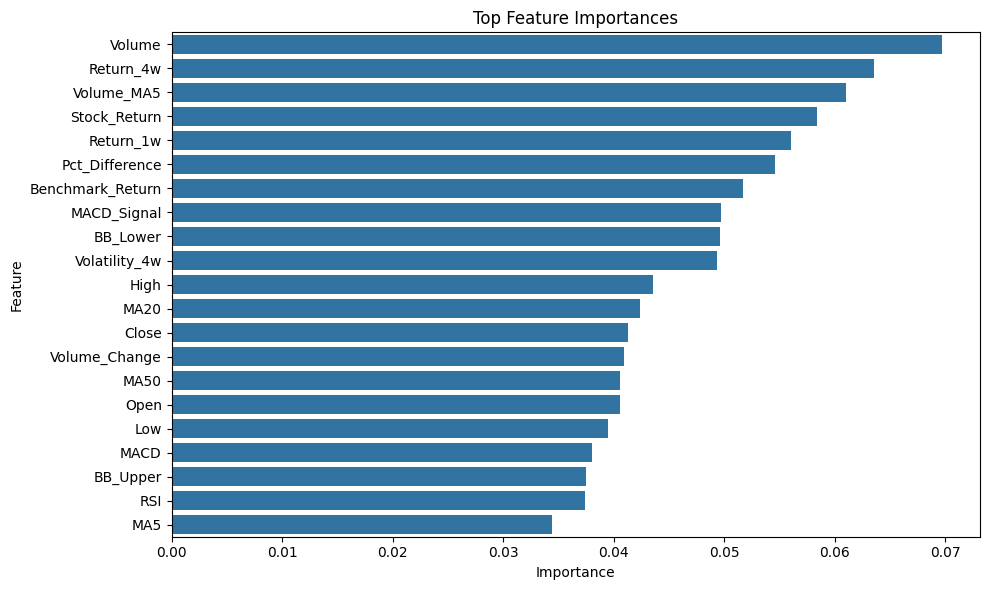

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

# Get feature importances and names
feature_columns = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
feat_imp_df.sort_values(by='Importance', ascending=False)

### Correlation Analysis

In [ ]:
# Compute correlation matrix on the training features
exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

numeric_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
corr_matrix = train_data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Reduce Multicollinearity

In [11]:
selected_features = [
    'Volume',
    'Return_4w',
    'Volume_MA5',
    'Stock_Return',
    'Return_1w',
    'Pct_Difference',
    'Benchmark_Return'
]

### Train/Test Split & Preprocessing after Reduce Multicollinearity

In [12]:
from itertools import combinations
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import time

import matplotlib.pyplot as plt

# Store the best combination and its score
best_combination = None
best_score = 0
scores = []

# Function to evaluate a combination of features
def evaluate_combination(combo):
    # Preprocess data with the current combination of features
    start_time = time.time()
    X_train_combo = train_data[list(combo)]
    X_test_combo = test_data[list(combo)]

    rf_model = RandomForestClassifier(
        max_depth=None,
        max_features=None,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=500,
        bootstrap=False
    )
    # Train the model
    rf_model.fit(X_train_combo, y_train)

    # Predict and evaluate
    y_pred_combo = rf_model.predict(X_test_combo)
    score = f1_score(y_test, y_pred_combo)
    presision = classification_report(y_test, y_pred_combo, output_dict=True)["1"]["precision"]
    
    print(f"Combination: {combo}, F1 Score: {score}, Precision: {presision}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")

    return combo, score

# Run combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combination)(combo)
    for r in range(1, len(selected_features) + 1)
    for combo in combinations(selected_features, r)
)

# Collect and rank results
scores = sorted(results, key=lambda x: x[1], reverse=True)
best_combination, best_score = scores[0]

print(f"Best combination: {best_combination}")
print(f"Best F1 Score: {best_score}")

Combination: ('Volume_MA5',), F1 Score: 0.3, Precision: 0.6
Time taken: 0.86 seconds
Combination: ('Volume',), F1 Score: 0.43478260869565216, Precision: 0.625
Time taken: 1.00 seconds
Combination: ('Pct_Difference',), F1 Score: 0.3333333333333333, Precision: 0.4444444444444444
Time taken: 1.00 seconds
Combination: ('Volume', 'Volume_MA5'), F1 Score: 0.3333333333333333, Precision: 1.0
Time taken: 0.95 seconds
Combination: ('Volume', 'Pct_Difference'), F1 Score: 0.37037037037037035, Precision: 0.4166666666666667
Time taken: 0.91 seconds
Combination: ('Return_1w',), F1 Score: 0.6666666666666666, Precision: 0.75
Time taken: 0.89 seconds
Combination: ('Volume', 'Stock_Return'), F1 Score: 0.5185185185185185, Precision: 0.5833333333333334
Time taken: 0.98 seconds
Combination: ('Volume', 'Return_1w'), F1 Score: 0.5185185185185185, Precision: 0.5833333333333334
Time taken: 1.06 seconds
Combination: ('Volume', 'Return_4w'), F1 Score: 0.5925925925925926, Precision: 0.6666666666666666
Time taken: 

In [13]:
results.sort(key=lambda x: x[1], reverse=True)
results

[(('Volume', 'Return_4w', 'Stock_Return'), 0.8125),
 (('Volume', 'Return_4w', 'Return_1w', 'Benchmark_Return'),
  0.7741935483870968),
 (('Return_4w', 'Stock_Return'), 0.7647058823529411),
 (('Return_4w', 'Return_1w'), 0.7647058823529411),
 (('Return_4w', 'Stock_Return', 'Return_1w'), 0.7647058823529411),
 (('Return_4w', 'Benchmark_Return'), 0.7407407407407407),
 (('Volume', 'Return_4w', 'Benchmark_Return'), 0.7096774193548387),
 (('Stock_Return', 'Pct_Difference'), 0.6923076923076923),
 (('Return_1w', 'Pct_Difference'), 0.6923076923076923),
 (('Stock_Return', 'Return_1w', 'Pct_Difference'), 0.6923076923076923),
 (('Volume', 'Return_4w', 'Return_1w'), 0.6896551724137931),
 (('Volume', 'Return_4w', 'Stock_Return', 'Return_1w'), 0.6896551724137931),
 (('Stock_Return',), 0.6666666666666666),
 (('Return_1w',), 0.6666666666666666),
 (('Stock_Return', 'Return_1w'), 0.6666666666666666),
 (('Volume', 'Return_4w', 'Stock_Return', 'Return_1w', 'Benchmark_Return'),
  0.6428571428571429),
 (('Volu

### Apply best combination

In [ ]:
# Apply the specified hyperparameters and best feature combination
rf_model = RandomForestClassifier(
    max_depth=None,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    bootstrap=False
)

# exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next', 'Open', 'High', 'Low']
# select_features = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']

# Use the best combination of features
select_features = ['Volume', 'Return_4w', 'Stock_Return']

# Create test and train sets
train_data = labeled_df[labeled_df["Date"] < "2025-01-01"]
test_data = labeled_df[labeled_df["Date"] >= "2025-01-01"]

In [15]:
print(train_data['Label'].value_counts())
print(test_data['Label'].value_counts())

Label
1    108
0    103
Name: count, dtype: int64
Label
1    9
0    8
Name: count, dtype: int64


In [16]:
# Create a new DataFrame with the selected features
X_train = train_data[select_features]
X_test = test_data[select_features]
y_train = train_data["Label"]
y_test = test_data["Label"]

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.75      1.00      0.86         9

    accuracy                           0.82        17
   macro avg       0.88      0.81      0.81        17
weighted avg       0.87      0.82      0.82        17



Train with all data except last row of Symbol

In [17]:
# Create train and test sets
train_data = labeled_df.iloc[:-1]  # All rows except the last one
test_data = labeled_df.iloc[-1:]  # Only the last row

In [18]:
print(train_data['Label'].value_counts())
print(test_data['Label'].value_counts())

Label
1    116
0    111
Name: count, dtype: int64
Label
1    1
Name: count, dtype: int64


In [20]:
# Create a new DataFrame with the selected features
X_train = train_data[select_features]
X_test = test_data[select_features]
y_train = train_data["Label"]
y_test = test_data["Label"]

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Show the prediction
print(f"Predicted label for the last row: {y_pred[0]}")
print(f"Actual label for the last row: {y_test.values[0]}")

Predicted label for the last row: 1
Actual label for the last row: 1


### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None],
    'bootstrap': [False]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)

###  Cross-Validation Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='f1')

# Print the results
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))